In [1]:
import sys
!{sys.executable} -m pip install xgboost
import pandas as pd
import numpy as np
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from diabetes_utils import clean_diabetes_data, plot_and_save_metrics

# 1) Load raw dataset and run our cleaning function
diabetes_data = fetch_ucirepo(id=296)
X_raw = diabetes_data.data.features
y_raw = diabetes_data.data.targets

if "readmitted" not in y_raw.columns:
    y_raw.columns = ["readmitted"]

df_raw = pd.concat([X_raw, y_raw], axis=1)
df_clean = clean_diabetes_data(df_raw)

print("Cleaned shape:", df_clean.shape)
print(df_clean.head())

# 2) Build feature matrix for XGBoost
# Target is the binary 30-day readmission flag from the cleaner
target_col = "readmit_30d"

df_xgb = df_clean.copy()
y = df_xgb[target_col].values
df_xgb = df_xgb.drop(columns=["readmitted", target_col])  # drop raw label + target

# treat object columns as categorical and label-encode them
cat_cols = df_xgb.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in df_xgb.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_xgb[col] = le.fit_transform(df_xgb[col].astype(str))
    encoders[col] = le

X = df_xgb.values
print("Feature matrix shape:", X.shape)

# 3) Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Positive rate (train):", y_train.mean().round(3))

# 4) Define XGBoost classifier
# Use AUC as eval_metric (this is our c-statistic)
# Use early stopping on a validation set (the held-out test split here)

# simple class-weighting for imbalance
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print("scale_pos_weight:", round(pos_weight, 2))

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",     
    n_estimators=500,        
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    n_jobs=4,
    early_stopping_rounds=20
)

# 5) Fit model with early stopping
# XGBoost will watch AUC on the validation set and keep the best iteration
xgb_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

print("Best iteration:", xgb_clf.best_iteration)


# 6) Evaluate and save plots
# predict_proba gives probabilities for class 0 and 1
y_prob = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

xgb_results = {
    "accuracy": round(accuracy_score(y_test, y_pred), 3),
    "roc_auc":  round(roc_auc_score(y_test, y_prob), 3),
    "f1_pos":   round(f1_score(y_test, y_pred, zero_division=0), 3),
}

print("\nXGBoost model results:")
for k, v in xgb_results.items():
    print(f"  {k}: {v}")

# Save plots
plot_and_save_metrics("xgboost", y_test, y_prob)

# Save probabilites
np.save("y_test_xgb.npy", y_test)
np.save("probs_xgb.npy", y_prob)

C:\Users\Timothy\AppData\Local\Programs\Python\Python39\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Cleaned shape: (101766, 49)
              race  gender      age  admission_type_id  \
0        Caucasian  Female   [0-10)                  6   
1        Caucasian  Female  [10-20)                  1   
2  AfricanAmerican  Female  [20-30)                  1   
3        Caucasian    Male  [30-40)                  1   
4        Caucasian    Male  [40-50)                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        25                    1                 1   
1                         1                    7                 3   
2                         1                    7                 2   
3                         1                    7                 2   
4                         1                    7                 1   

   num_lab_procedures  num_procedures  num_medications  ...  \
0                  41               0                1  ...   
1                  59               0               18  ...   
2            

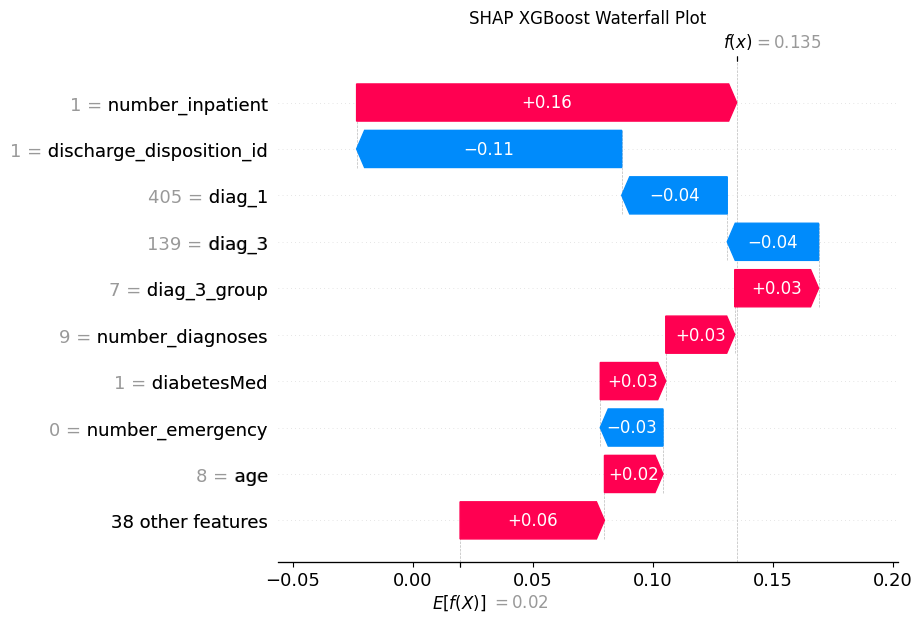

In [16]:
import shap

model = xgb_clf
X_test_df = pd.DataFrame(X_test, columns=df_xgb.columns)
explainer = shap.Explainer(model)
shap_values = explainer(X_test_df)
shap.initjs()

shap.waterfall_plot(shap_values[0], show=False)
plt.title("SHAP XGBoost Waterfall Plot")
plt.savefig("shap_xgboost_waterfall_plot.png", bbox_inches='tight')
plt.show()